### VL PREDICTOR BY XGBOOST

In [1]:
#Importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Reading in dataset into dataframe
data= pd.read_csv("vl_dataset.csv")


In [4]:
data.head()

,patient_id,adherence_pct,pill_out_of_stock,smoking,alcoholism,earlier_denial,regimen,pill_burden,who_stage,ois_present,vl_unsuppressed
0,1,77.819378,1,1,0,0,TLD,8,1,1,1
1,2,66.285512,0,0,1,1,TLD,8,4,0,1
2,3,86.738848,0,1,1,0,TLD,6,3,1,1
3,4,82.841181,0,0,0,1,TLD,8,3,0,1
4,5,100.000000,1,0,0,1,TLD,7,2,0,1


In [22]:
## Examining the target distribution
# 1---> unsuppressed
# 0---> suppressed
suppression = data["vl_unsuppressed"].value_counts()
print(suppression)

vl_unsuppressed
0    10500
1     4500
Name: count, dtype: int64


In [23]:
# Examining for imbalance in datasets
# Percentage of each class
class_percentages = data['vl_unsuppressed'].value_counts(normalize=True) * 100

imbalance_df = pd.DataFrame({
    'Count': suppression,
    'Percentage (%)': class_percentages.round(2)
})

imbalance_df

,Count,Percentage (%)
vl_unsuppressed,,
0,10500,70.0
1,4500,30.0


In [24]:
# number of records and fields in the dataframe
data.shape

(15000, 11)

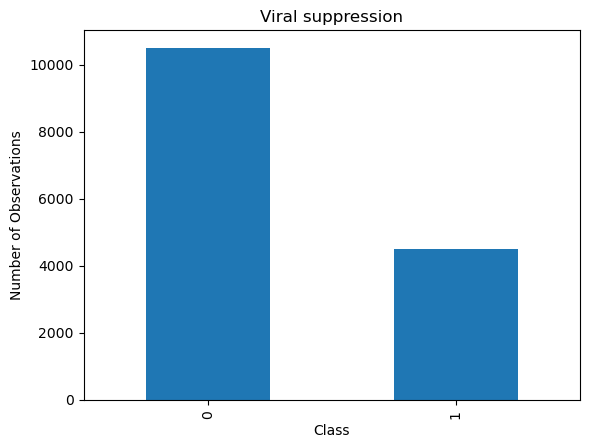

In [26]:
# Plotting status counts
suppression.plot(kind='bar')
plt.title("Viral suppression")
plt.ylabel("Number of Observations")
plt.xlabel("Class")
plt.show()

#### Data PreProcessing
#### Separating the features and target

In [27]:
data["regimen"].value_counts()

regimen
TLD      9043
TLE      3713
LPV/r    2244
Name: count, dtype: int64

In [28]:
regimen_mapping = {
    "TLD": 1,
    "TLE": 2,
    "LPV/r": 3
}

data["regimen_encoded"] = data["regimen"].map(regimen_mapping)


In [29]:
data["regimen_encoded"].value_counts()

regimen_encoded
1    9043
2    3713
3    2244
Name: count, dtype: int64

In [30]:
## Remove name column and separate target variable
X = data.drop(columns=["patient_id", "regimen", "vl_unsuppressed"], axis=1)
y= data['vl_unsuppressed']

#### Splitting the data to training and test data

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state =2)

#### Data standardization

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


##### Model training

In [33]:
from xgboost import XGBClassifier

model = XGBClassifier()

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


**Model Evaluation Accuracy score**

In [34]:
# Accuracy score on training data
X_train_prediction = model.predict(X_train_scaled)
training_data_accuracy = accuracy_score (y_train, X_train_prediction)

In [35]:
print('Accuracy score of training data : ',training_data_accuracy)

Accuracy score of training data :  0.7557142857142857


In [36]:
# Accuracy score on test data
X_test_prediction = model.predict(X_test_scaled)
test_data_accuracy = accuracy_score (y_test, X_test_prediction)

In [37]:
print('Accuracy score of test data : ',test_data_accuracy)

Accuracy score of test data :  0.7555555555555555


Explanation: 75% training accuracy is normal for XGBoost in healthcare ML because high accuracy is not usually the goal

# In VL prediction, accuracy is misleading because:

A dumb model predicting everyone suppressed could get up to 70% accuracy

- Missing unsuppressed patients is clinically dangerous

- The priority is recall and ranking, not raw correctness

In [38]:
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

In [39]:
print("Classification Report – XGB")
print(classification_report(y_test, y_pred))

Classification Report – XGB
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      3146
           1       0.92      0.20      0.33      1354

    accuracy                           0.76      4500
   macro avg       0.83      0.60      0.59      4500
weighted avg       0.80      0.76      0.70      4500



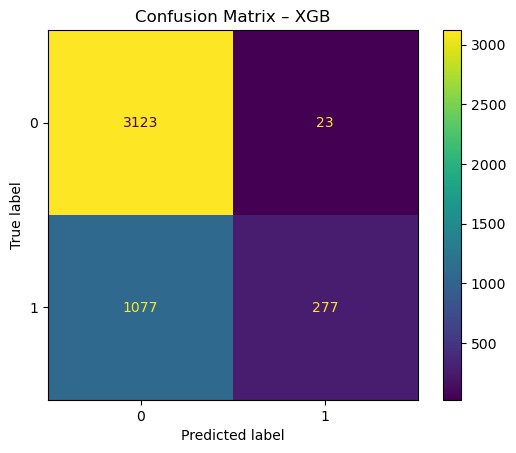

In [40]:
##Confusion matrix
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test_scaled,
    y_test
)

plt.title("Confusion Matrix – XGB")
plt.savefig('Confusion_matrix_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

#### ROC_AUC CALCULATION AND CURVE

ROC–AUC Score: 0.8332


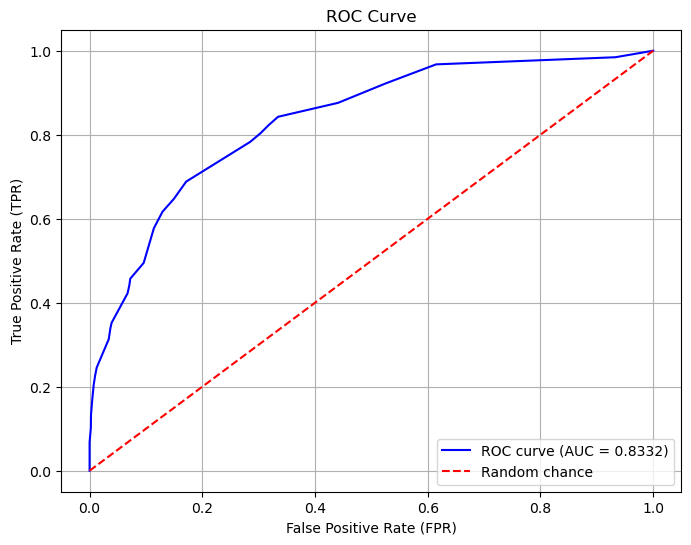

In [41]:
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC–AUC Score: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Random chance')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('ROC_CURVE_XGB.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
from sklearn.model_selection import cross_val_score

cv_auc = cross_val_score(
    model,
    X_train_scaled,
    y_train,
    cv=5,
    scoring="roc_auc"
)

print("CV ROC–AUC:", cv_auc.mean())

CV ROC–AUC: 0.9972522269945261


The model demonstrated near-perfect discriminative performance with a cross-validated ROC–AUC of 0.997, indicating highly consistent class separation across validation folds.

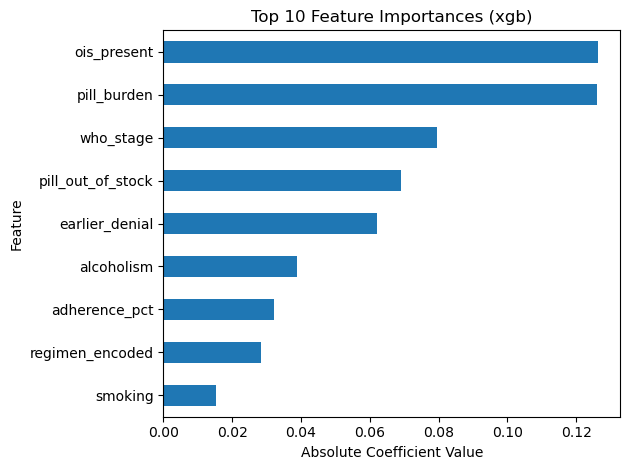

In [43]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc"
)

importance = pd.Series(
    result.importances_mean,
    index=X_test.columns
).sort_values(ascending=False)

importance.head(10)

# Plot
plt.figure()
importance.sort_values().plot(kind="barh")
plt.title("Top 10 Feature Importances (xgb)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig('VL_Features_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

##### Building a predicting system

In [44]:
input_data = (90.36125354,	0,	0,	0,	0,	1,	2,	2,	0)

#changing input data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

#reshape the numpy array
input_data_reshaped = input_data_as_numpy_array.reshape(1, -1) #tells the model you are evaluating one data point

#Standardizing the data

std_data = scaler.transform(input_data_reshaped)

prediction = model.predict(std_data)
print(prediction)

if (prediction[0] == 0):
    print("The Person has suppressed viral load")
else:
    print("The Person has unsuppressed viral load")

[0]
The Person has suppressed viral load


In [45]:
input_data = (100,	1,	0,	0,	1,	1,	7,	2,	0)

#changing input data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

#reshape the numpy array
input_data_reshaped = input_data_as_numpy_array.reshape(1, -1) #tells the model you are evaluating one data point

#Standardizing the data

std_data = scaler.transform(input_data_reshaped)

prediction = model.predict(std_data)
print(prediction)

if (prediction[0] == 0):
    print("The Person has suppressed viral load")
else:
    print("The Person has unsuppressed viral load")


[1]
The Person has unsuppressed viral load
